### vgg19-cifar10-keras

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,load_img,to_categorical
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [3]:
x_train=x_train[::100]
y_train=y_train[::100]

x_test=x_test[::100]
y_test=y_test[::100]

In [4]:
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

print("Shape of x_test: ",x_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of x_train:  (500, 32, 32, 3)
Shape of y_train:  (500, 1)
Shape of x_test:  (100, 32, 32, 3)
Shape of y_test:  (100, 1)


In [5]:
y_train[:5]

array([[6],
       [8],
       [6],
       [2],
       [2]], dtype=uint8)

In [6]:
numberOfClass=len(np. unique(y_train))

In [7]:
y_train=to_categorical(y_train,numberOfClass)
y_test=to_categorical(y_test,numberOfClass)

In [8]:
y_train[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
input_shape=x_train.shape[1:]
input_shape

(32, 32, 3)

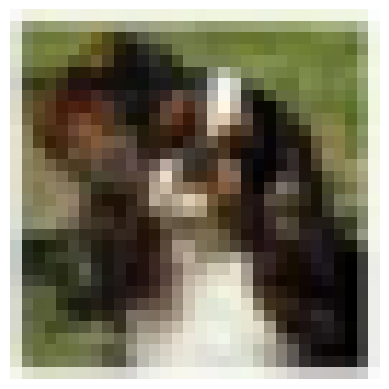

In [10]:
plt.imshow(x_train[5].astype(np.uint8))
plt.axis("off")

plt.show()

In [11]:
#vgg19 모형에 맞게 48x48로 resize

import cv2

def resize_img(img):
    numberOfImage=img.shape[0]
    new_array=np.zeros((numberOfImage,48,48,3))

    for i in range(numberOfImage):
        new_array[i]=cv2.resize(img[i,:,:,:],(48,48))

    return new_array   

x_train=resize_img(x_train)
x_test=resize_img(x_test)

print(x_train.shape, x_test.shape)

(500, 48, 48, 3) (100, 48, 48, 3)


In [12]:
vgg=VGG19(include_top=False,weights="imagenet",input_shape=(48,48,3))
#               output 제외

vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# transfer learning(전이학습) - 출력층만 학습
# fine tuning(미세조정) - 모든 레이어 재학습

In [13]:
for layer in vgg.layers:
    layer.trainable=False   # 추론모드

In [14]:
layer=[
       layers.Flatten(),
       layers.Dense(128),
       layers.Dense(numberOfClass,activation="softmax"),
       ]

model=tf.keras.Sequential(vgg.layers+layer)
#                         사전훈련모델 출력

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

In [15]:
model.compile(loss="categorical_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])

In [16]:
import gc

tf.keras.backend.clear_session()
gc.collect()    # 쓰레기 수집

516

In [17]:
import tensorflow as tf
with tf.device('/:GPU0'):
    hist=model.fit(x_train,y_train,validation_split=0.3, epochs=5,batch_size=1)

Epoch 1/5
350/350 [==============================] - 13s 36ms/step - loss: 20.9204 - accuracy: 0.2743 - val_loss: 20.4366 - val_accuracy: 0.2867
Epoch 2/5
350/350 [==============================] - 12s 35ms/step - loss: 8.0177 - accuracy: 0.5800 - val_loss: 23.6456 - val_accuracy: 0.3267
Epoch 3/5
350/350 [==============================] - 12s 35ms/step - loss: 5.2676 - accuracy: 0.6657 - val_loss: 21.7847 - val_accuracy: 0.3533
Epoch 4/5
350/350 [==============================] - 12s 35ms/step - loss: 3.0871 - accuracy: 0.8057 - val_loss: 22.8276 - val_accuracy: 0.4133
Epoch 5/5
350/350 [==============================] - 12s 35ms/step - loss: 2.8222 - accuracy: 0.8200 - val_loss: 24.5079 - val_accuracy: 0.3733


In [18]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


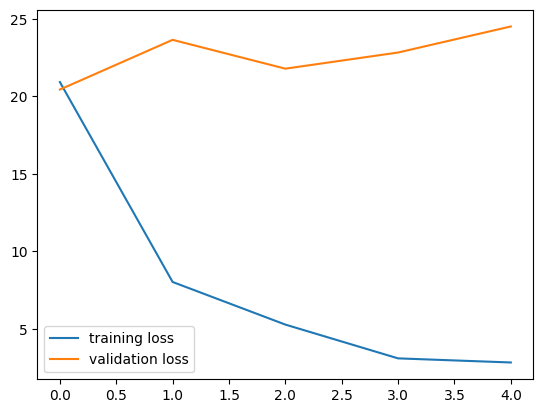

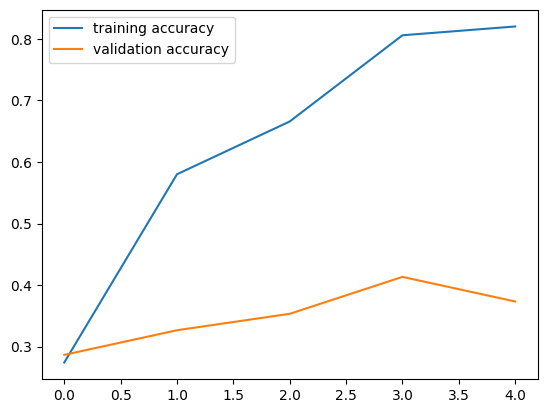

In [19]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()

plt.show()

plt.figure()
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()

plt.show()

In [20]:
model.evaluate(x_test,y_test)

4/4 [==============================] - 2s 138ms/step - loss: 20.7740 - accuracy: 0.3400


[20.774002075195312, 0.3400000035762787]